In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/imagenet/")
list((PATH/'train').iterdir())

[WindowsPath('../data/imagenet/train/n01440764'),
 WindowsPath('../data/imagenet/train/n01443537'),
 WindowsPath('../data/imagenet/train/n01491361'),
 WindowsPath('../data/imagenet/train/n01494475'),
 WindowsPath('../data/imagenet/train/n01498041'),
 WindowsPath('../data/imagenet/train/n01514668'),
 WindowsPath('../data/imagenet/train/n01514859'),
 WindowsPath('../data/imagenet/train/n01518878'),
 WindowsPath('../data/imagenet/train/n01530575'),
 WindowsPath('../data/imagenet/train/n01531178'),
 WindowsPath('../data/imagenet/train/n01534433'),
 WindowsPath('../data/imagenet/train/n01537544'),
 WindowsPath('../data/imagenet/train/n01558993'),
 WindowsPath('../data/imagenet/train/n01560419'),
 WindowsPath('../data/imagenet/train/n01580077'),
 WindowsPath('../data/imagenet/train/n01582220'),
 WindowsPath('../data/imagenet/train/n01592084'),
 WindowsPath('../data/imagenet/train/n01608432'),
 WindowsPath('../data/imagenet/train/n01614925'),
 WindowsPath('../data/imagenet/train/n01616318'),


In [3]:
L = list((PATH/'train').iterdir())

In [4]:
L1 = L[1].glob('*')

In [5]:
list(L1)

[WindowsPath('../data/imagenet/train/n01443537/n01443537_10171.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_1087.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_11207.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_13189.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_14804.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_16057.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_16464.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_16533.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_16849.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_17255.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_18846.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_19650.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_20026.JPEG'),
 WindowsPath('../data/imagenet/train/n01443537/n01443537_20489.JPEG'),
 Window

In [6]:
filenames, classes = [],[]
TRN_PATH = (PATH/'train')
for directory in TRN_PATH.iterdir():
    for fn in directory.glob('*'):
        filenames.append(str(fn)[len(str(TRN_PATH))+1:])
        classes.append(str(directory)[len(str(TRN_PATH))+1:])
class_names = list(set(classes))
class2idx = {c:i for i,c in enumerate(class_names)}
labels = [class2idx[c] for c in classes]

In [7]:
df = pd.DataFrame({'filenames':filenames, 'cats':labels}, columns=['filenames', 'cats'])

In [8]:
df.head()

,filenames,cats
0,n01440764\n01440764_10365.JPEG,682
1,n01440764\n01440764_11155.JPEG,682
2,n01440764\n01440764_11787.JPEG,682
3,n01440764\n01440764_12241.JPEG,682
4,n01440764\n01440764_12732.JPEG,682


In [9]:
df.to_csv(PATH/'train.csv', index=False)

In [10]:
stats = (np.array([0.485, 0.456, 0.406]), np.array([ 0.229, 0.224, 0.225]))

In [11]:
def get_data(sz,bs):
    tfms = tfms_from_model(resnet50,sz)
    return ImageClassifierData.from_csv(PATH,'train',PATH/'train.csv',bs=bs, tfms=tfms)

In [12]:
size = 256
batch_size = 32
data = get_data(size,batch_size)

# Resnet 50

Even if I'll use the one from pytorch to be **really** sure it's the good one, it doesn't harm to rewrite it.

In [6]:
class Bottleneck(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        ch_hid = ch_out//4
        self.bn1 = nn.BatchNorm2d(ch_hid)
        self.conv1 = nn.Conv2d(ch_in, ch_hid, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_hid)
        self.conv2 = nn.Conv2d(ch_hid, ch_hid, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ch_out)
        self.conv3 = nn.Conv2d(ch_hid, ch_out, kernel_size=1, stride=1, padding=0, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += shortcut
        return F.relu(out)

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_group_layer(64, 256, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(256, 512, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(512, 1024, num_blocks[2], stride=2)
        self.layer4 = self.make_group_layer(1024, 2048, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [Bottleneck(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(Bottleneck(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3,stride=2,padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [17]:
resnet50a = ResNet([3,4,6,3])

Now the one from pytorch.

In [37]:
from torchvision.models import resnet50

In [38]:
class addLast(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.linear = nn.Linear(8192,1000)
    
    def forward(self,x):
        out = self.model(x)
        out = out.view(out.size(0),-1)
        return F.log_softmax(self.linear(out))

In [39]:
resnet50py = resnet50()
removed = list(resnet50py.children())[:-1]
resnet50py = addLast(nn.Sequential(*removed))

In [43]:
learn1 = ConvLearner.from_model_data(resnet50py, data)
learn1.crit = F.nll_loss

In [41]:
learn1.lr_find()

epoch      trn_loss   val_loss   accuracy                   
    0      6.896336   9.951899   0.000772  



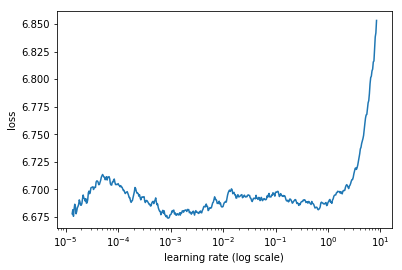

In [42]:
learn1.sched.plot()

In [44]:
learn1.fit(0.5,3)

epoch      trn_loss   val_loss   accuracy                   
    0      6.75804    9.671463   0.002058  
    1      6.723974   9.446687   0.001029                   
    2      6.713316   9.101116   0.002573                   



[9.101116424542882, 0.002572678157962439]

# PreAct Resnet

Won't be used, but useful to warm up.

In [58]:
class PreActBottleneck(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        ch_hid = ch_out//4
        self.bn1 = nn.BatchNorm2d(ch_in)
        self.conv1 = nn.Conv2d(ch_in, ch_hid, kernel_size=1, stride=stride, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_hid)
        self.conv2 = nn.Conv2d(ch_hid, ch_hid, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(ch_hid)
        self.conv3 = nn.Conv2d(ch_hid, ch_out, kernel_size=1, stride=1, padding=0, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else out
        out = F.relu(self.bn2(self.conv1(x)))
        out = F.relu(self.bn3(self.conv2(out)))
        out = self.conv3(out)
        out += shortcut
        return out

In [63]:
class PreActResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_group_layer(64, 256, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(256, 512, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(512, 1024, num_blocks[2], stride=2)
        self.layer4 = self.make_group_layer(1024, 2048, num_blocks[3], stride=2)
        self.bn2 = nn.BatchNorm2d(2048)
        self.linear = nn.Linear(2048, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [PreActBottleneck(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(Bottleneck(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3,stride=2,padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn2(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [64]:
preactresnet50 = PreActResNet([3,4,6,3])

# Darknet

In [13]:
class ConvBN(nn.Module):#convolutional layer then Batchnorm
    
    def __init__(self, ch_in, ch_out, kernel_size = 3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch_out)

    def forward(self, x):
        return self.bn(self.conv(x))

In [14]:
class DarknetBlock(nn.Module):#The basic blocs.
    
    def __init__(self, ch_in):
        super().__init__()
        ch_hid = ch_in//2
        self.conv1 = ConvBN(ch_in, ch_hid, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBN(ch_hid, ch_in, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x),0.1)
        out = self.conv2(out)
        out += x
        return F.leaky_relu(out)

In [15]:
class Darknet(nn.Module):#Table 1 from the YOLOv3 paper
    def __init__(self, num_blocks, num_classes=1000):
        super().__init__()
        self.conv = ConvBN(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer1 = self.make_group_layer(32, num_blocks[0])
        self.layer2 = self.make_group_layer(64, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(128, num_blocks[2], stride=2)
        self.layer4 = self.make_group_layer(256, num_blocks[3], stride=2)
        self.layer5 = self.make_group_layer(512, num_blocks[4], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def make_group_layer(self, ch_in, num_blocks, stride=1):
        layers = [ConvBN(ch_in,ch_in*2,kernel_size=3, stride=stride, padding=1)]
        for i in range(num_blocks):
            layers.append(DarknetBlock(ch_in*2))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.conv(x),0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [16]:
darknet53 = Darknet([1,2,8,8,4])

In [17]:
learn = ConvLearner.from_model_data(darknet53, data)
learn.crit = F.nll_loss

In [18]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 864)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 32, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 64)])),
             ('ConvBN-3',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 32, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 32, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', True),
                           ('nb_params', 18432)])),
             ('BatchNorm2d-5',
   

In [29]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                   
    0      6.990798   832656.150132 0.001801  



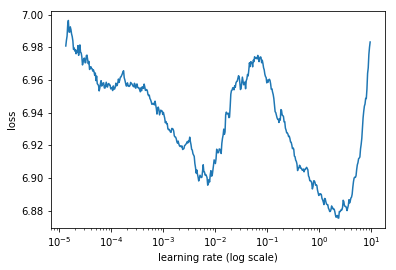

In [31]:
learn.sched.plot(10,1)

In [32]:
learn.fit(0.5,3)

epoch      trn_loss   val_loss   accuracy                   
    0      6.749389   6.731229   0.002058  
    1      6.675226   6.925622   0.002573                   
    2      6.619818   6.710072   0.002573                   



[6.7100721885037355, 0.002572678157962439]